# Zomato Bangalore Restaurants Classification

By: Mohamed Fawzy

In [11]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import joblib

sns.set(rc={'figure.figsize':(14, 10)}, font_scale=1.2)

In [12]:
# Read the dataset
df = pd.read_csv('Zomato Bangalore Restaurants.csv')

### Describing Data:

In [13]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [15]:
for col in df.columns:
    print(f'Unique values for ({col}): {len(df[col].unique())}')

Unique values for (url): 51717
Unique values for (address): 11495
Unique values for (name): 8792
Unique values for (online_order): 2
Unique values for (book_table): 2
Unique values for (rate): 65
Unique values for (votes): 2328
Unique values for (phone): 14927
Unique values for (location): 94
Unique values for (rest_type): 94
Unique values for (dish_liked): 5272
Unique values for (cuisines): 2724
Unique values for (approx_cost(for two people)): 71
Unique values for (reviews_list): 22513
Unique values for (menu_item): 9098
Unique values for (listed_in(type)): 7
Unique values for (listed_in(city)): 30


In [16]:
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


## Data Exploration:

In [17]:
df['url'].value_counts()

https://www.zomato.com/bangalore/jalsa-banashankari?context=eyJzZSI6eyJlIjpbNTg2OTQsIjE4Mzc1NDc0IiwiNTkwOTAiLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHMgaW4gQmFuYXNoYW5rYXJpIHNlcnZpbmcgQnVmZmV0In19                                                                                                                                                                                                                                            1
https://www.zomato.com/bangalore/al-hayath-btm-bangalore?context=eyJzZSI6eyJlIjpbIjUyNTMwIiwiMTg3ODEzNjAiLCIxODc5MTA5MiIsIjE4ODI0MTc0Iiw2MTIxMCwiNTA2NjkiLCIxODY4MDEwNCIsIjE4MTQwNzgwIiwiMTg4NDU0NzYiLCIxODc4NTExMiIsIjE4NjY3NjQ1IiwiMTg3ODExMDUiLCI1NTM3MyIsIjE4NjgwNTAzIiwiMTg0MTc1OTYiXSwidCI6IkRpbmUtT3V0IFJlc3RhdXJhbnRzIGluIEtvcmFtYW5nYWxhIDZ0aCBCbG9jayJ9fQ==                                                                                                               1
https://www.zomato.com/bangalore/donne-biriyani-house-hsr-ba

In [18]:
df['address'].value_counts()

Delivery Only                                                                               128
14th Main, 4th Sector, HSR, Bangalore                                                        71
The Ritz-Carlton, 99, Residency Road, Bangalore                                              61
Citrus Hotels, 34, Cunningham Road, Bangalore                                                53
Conrad Bengaluru, Kensington Road, Ulsoor, Bangalore                                         49
                                                                                           ... 
9/53, Near Kanti Sweets, 5th Main Road, Ganganagar, RT Nagar, Bangalore                       1
94 Neeladri Nagar, 14th Cross Neeladri Main Road, Doddatogur, Electronic City, Bangalore      1
12, Rahmathnagar Bus Stop, RT Nagar, Bangalore                                                1
SJR Equinox, Opposite Velankani Gate 3, Phase1, Electronic City, Bangalore                    1
B K Rama Reddy, Virat Nagar Circle, Bomm

In [19]:
df['name'].value_counts()

Cafe Coffee Day                                            96
Onesta                                                     85
Just Bake                                                  73
Empire Restaurant                                          71
Five Star Chicken                                          70
                                                           ..
Natis                                                       1
Shreyas                                                     1
Vishwas Kabab Centre                                        1
Taj Biryani Centre                                          1
Plunge - Sheraton Grand Bengaluru Whitefield Hotel &...     1
Name: name, Length: 8792, dtype: int64

In [20]:
df['phone'].value_counts()

080 43334321                          216
080 43334333                          167
+91 7005889963                         78
+91 8197170008                         75
+91 7710055553                         58
                                     ... 
+91 9845687999\r\r\n080 41494199        1
+91 9606443393\r\r\n+91 9606443394      1
+91 9538798222                          1
080 48902064\r\r\n+91 9620723546        1
+91 8884297989\r\r\n+91 9886759367      1
Name: phone, Length: 14926, dtype: int64

In [21]:
df['reviews_list'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [22]:
df['menu_item'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [23]:
df['approx_cost(for two people)'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '80', '1,100', '160',
       '1,600', '230', '130', '50', '190', '1,700', nan, '1,400', '180',
       '1,350', '2,200', '2,000', '1,800', '1,900', '330', '2,500',
       '2,100', '3,000', '2,800', '3,400', '40', '1,250', '3,500',
       '4,000', '2,400', '2,600', '120', '1,450', '469', '70', '3,200',
       '60', '560', '240', '360', '6,000', '1,050', '2,300', '4,100',
       '5,000', '3,700', '1,650', '2,700', '4,500', '140'], dtype=object)

In [24]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [25]:
df['listed_in(type)'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [26]:
print(f'Distinct count for (rest_type) column: {df["rest_type"].nunique()}')

lst1 = []

for i in df['rest_type'].unique():
    if i == 'nan':
        continue
    else:
        lst1.extend(str(i).split(','))

lst1 = [i.strip() for i in lst1]
lst1 = list(set(lst1))

print(f'Unique values for (rest_type): {len(lst1)}')

Distinct count for (rest_type) column: 93
Unique values for (rest_type): 26


In [27]:
print(f'Distinct count for (listed_in(city)) column: {df["listed_in(city)"].nunique()}')

lst2 = []

for i in df['listed_in(city)'].unique():
    if i == 'nan':
        continue
    else:
        lst2.extend(str(i).split(','))

lst2 = [i.strip() for i in lst2]
lst2 = list(set(lst2))

print(f'Unique values for (listed_in(city)): {len(lst2)}')

Distinct count for (listed_in(city)) column: 30
Unique values for (listed_in(city)): 30


In [28]:
print(f'Distinct count for (location) column: {df["location"].nunique()}')

lst3 = []

for i in df['location'].unique():
    if i == 'ITPL Main Road, Whitefield':
        lst3.append('ITPL Main Road, Whitefield')
    elif i == 'Varthur Main Road, Whitefield':
        lst3.append('Varthur Main Road, Whitefield')
    else:
        lst3.extend(str(i).split(','))

lst3 = [i.strip() for i in lst3]
lst3 = list(set(lst3))

print(f'Unique values for (location): {len(lst3)}')

Distinct count for (location) column: 93
Unique values for (location): 94


In [29]:
print(f'Distinct count for (cuisines) column: {df["cuisines"].nunique()}')

lst4 = []

for i in df['cuisines'].unique():
    if i == 'nan':
        continue
    else:
        lst4.extend(str(i).split(','))

lst4 = [i.strip() for i in lst4]
lst4 = list(set(lst4))

print(f'Unique values for (cuisines): {len(lst4)}')

Distinct count for (cuisines) column: 2723
Unique values for (cuisines): 108


In [30]:
print(f'Distinct count for (dish_liked) column: {df["dish_liked"].nunique()}')

lst5 = []

for i in df['dish_liked'].unique():
    if i == 'nan':
        continue
    else:
        lst5.extend(str(i).split(','))

lst5 = [i.strip() for i in lst5]
lst5 = list(set(lst5))

print(f'Unique values for (dish_liked): {len(lst5)}')

Distinct count for (dish_liked) column: 5271
Unique values for (dish_liked): 2793


## Data Preprocessing:

- Drop `url`, `address`, `name`, `phone`, `reviews_list`, `menu_item`, `dish_liked`

In [31]:
df.drop(['url', 'address', 'name', 'phone', 'reviews_list', 'menu_item', 'dish_liked'], axis=1, inplace=True)

- Handle values in `approx_cost(for two people)`

In [32]:
def approx_cost(x):
    x = str(x).replace(',', '')
    return float(x)

df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(approx_cost)

- Handle values in `rate`

In [33]:
df['rate'] = df['rate'].replace('NEW', np.nan)
df['rate'] = df['rate'].replace('-', np.nan)

def rate(x):
    x = str(x).split('/')[0].strip()
    return float(x)

df['rate'] = df['rate'].apply(rate)

- `online_order`, `book_table` should be converted to numerical

In [34]:
def online_order(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return x

def book_table(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return x

In [35]:
df['online_order'] = df['online_order'].apply(online_order)
df['book_table'] = df['book_table'].apply(book_table)

- Check for duplicate rows

In [36]:
df.duplicated().sum()

432

In [37]:
df.drop_duplicates(inplace=True)

- Arrange columns in dataframe

In [38]:
df = df[['approx_cost(for two people)', 'votes', 'online_order', 'book_table', 'listed_in(type)', 'rest_type', 'listed_in(city)', 'location', 'cuisines', 'rate']]

- Display data details and types

In [39]:
df.head()

,approx_cost(for two people),votes,online_order,book_table,listed_in(type),rest_type,listed_in(city),location,cuisines,rate
0,800.0,775,1,1,Buffet,Casual Dining,Banashankari,Banashankari,"North Indian, Mughlai, Chinese",4.1
1,800.0,787,1,0,Buffet,Casual Dining,Banashankari,Banashankari,"Chinese, North Indian, Thai",4.1
2,800.0,918,1,0,Buffet,"Cafe, Casual Dining",Banashankari,Banashankari,"Cafe, Mexican, Italian",3.8
3,300.0,88,0,0,Buffet,Quick Bites,Banashankari,Banashankari,"South Indian, North Indian",3.7
4,600.0,166,0,0,Buffet,Casual Dining,Banashankari,Basavanagudi,"North Indian, Rajasthani",3.8


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51285 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   approx_cost(for two people)  50944 non-null  float64
 1   votes                        51285 non-null  int64  
 2   online_order                 51285 non-null  int64  
 3   book_table                   51285 non-null  int64  
 4   listed_in(type)              51285 non-null  object 
 5   rest_type                    51060 non-null  object 
 6   listed_in(city)              51285 non-null  object 
 7   location                     51266 non-null  object 
 8   cuisines                     51242 non-null  object 
 9   rate                         41585 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 4.3+ MB


In [41]:
for col in df.columns:
    print(f'Unique values for ({col}): {len(df[col].unique())}')

Unique values for (approx_cost(for two people)): 71
Unique values for (votes): 2328
Unique values for (online_order): 2
Unique values for (book_table): 2
Unique values for (listed_in(type)): 7
Unique values for (rest_type): 94
Unique values for (listed_in(city)): 30
Unique values for (location): 94
Unique values for (cuisines): 2724
Unique values for (rate): 32


In [42]:
df.describe()

,approx_cost(for two people),votes,online_order,book_table,rate
count,50944.000000,51285.000000,51285.000000,51285.000000,41585.000000
mean,556.923779,285.059257,0.590933,0.125105,3.700164
std,439.331854,805.500277,0.491666,0.330841,0.440450
min,40.000000,0.000000,0.000000,0.000000,1.800000
25%,300.000000,7.000000,0.000000,0.000000,3.400000
50%,400.000000,42.000000,1.000000,0.000000,3.700000
75%,700.000000,200.000000,1.000000,0.000000,4.000000
max,6000.000000,16832.000000,1.000000,1.000000,4.900000


### EDA Results:

<AxesSubplot: xlabel='listed_in(type)', ylabel='approx_cost(for two people)'>

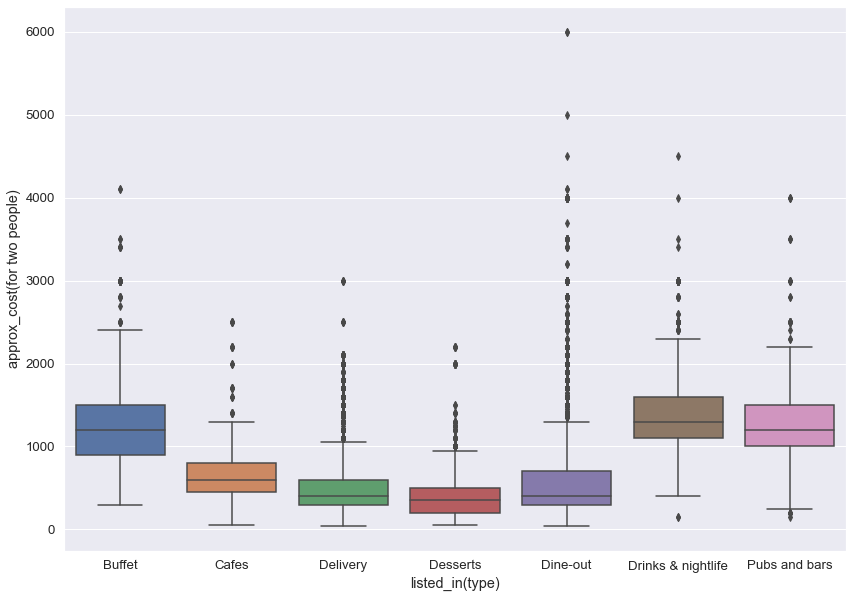

In [43]:
sns.boxplot(data=df, x='listed_in(type)', y='approx_cost(for two people)')

In [44]:
df[(df['listed_in(type)'] == 'Buffet') & (df['approx_cost(for two people)'] <= 2500)].sort_values(by='approx_cost(for two people)', ascending=False).head(10)

,approx_cost(for two people),votes,online_order,book_table,listed_in(type),rest_type,listed_in(city),location,cuisines,rate
42179,2500.0,688,0,1,Buffet,Fine Dining,MG Road,Richmond Road,"European, Continental, Chinese, Thai",4.3
11552,2500.0,679,0,1,Buffet,Fine Dining,Church Street,Richmond Road,"European, Continental, Chinese, Thai",4.3
47230,2500.0,689,0,1,Buffet,Fine Dining,Residency Road,Richmond Road,"European, Continental, Chinese, Thai",4.3
6753,2500.0,821,0,1,Buffet,Fine Dining,Brookefield,Whitefield,"North Indian, American, Italian",4.1
4989,2500.0,678,0,1,Buffet,Fine Dining,Brigade Road,Richmond Road,"European, Continental, Chinese, Thai",4.3
37681,2500.0,342,0,1,Buffet,Fine Dining,Lavelle Road,Race Course Road,"Italian, North Indian, Lebanese",4.1
40502,2500.0,764,0,1,Buffet,Fine Dining,Marathahalli,Marathahalli,"Continental, North Indian, Japanese, Italian",4.3
48852,2500.0,766,0,1,Buffet,Fine Dining,Sarjapur Road,Marathahalli,"Continental, North Indian, Japanese, Italian",4.3
11589,2500.0,339,0,1,Buffet,Fine Dining,Church Street,Race Course Road,"Italian, North Indian, Lebanese",4.1
39414,2400.0,371,0,1,Buffet,Fine Dining,Malleshwaram,Sankey Road,"North Indian, Continental, Asian",4.2


In [45]:
df = df[df['approx_cost(for two people)'] <= 2500]

<AxesSubplot: xlabel='approx_cost(for two people)', ylabel='Count'>

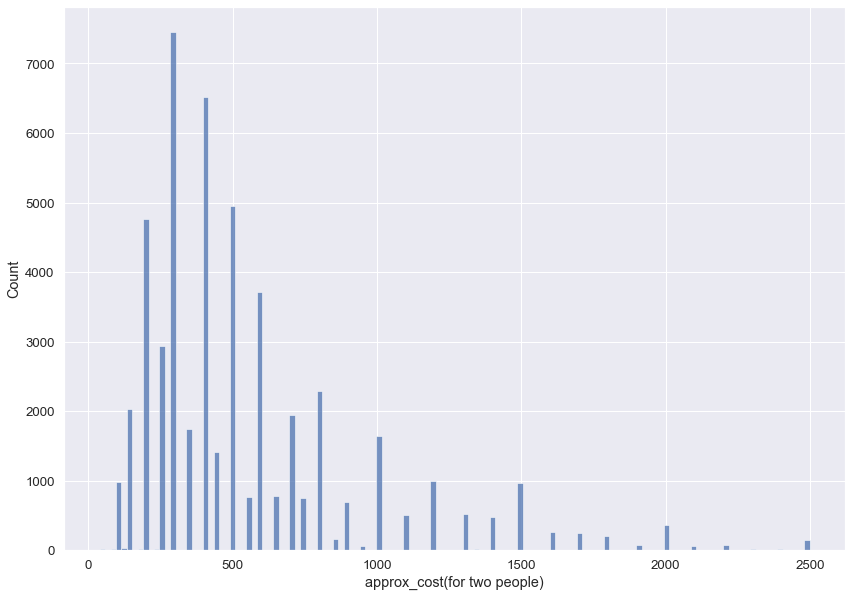

In [46]:
sns.histplot(data=df, x='approx_cost(for two people)')

<AxesSubplot: xlabel='approx_cost(for two people)', ylabel='Density'>

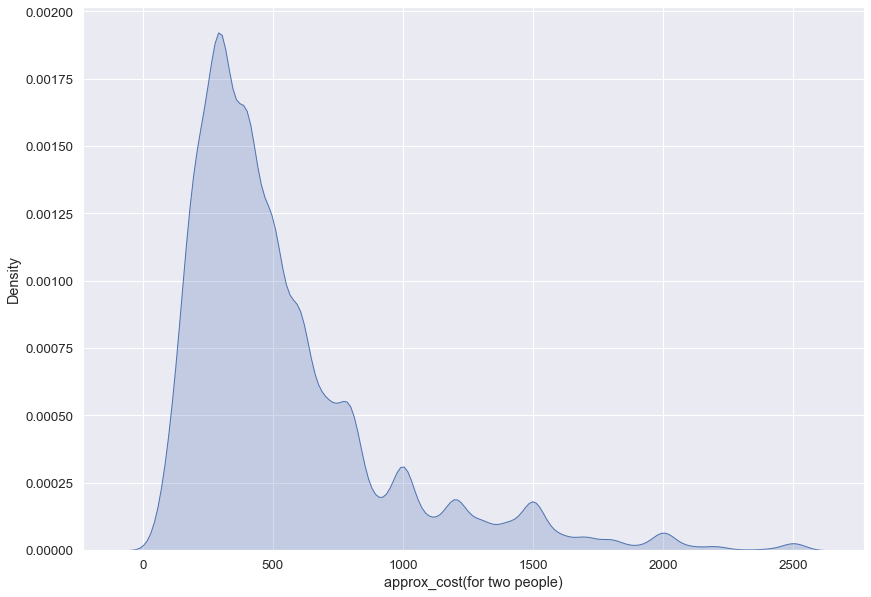

In [47]:
sns.kdeplot(df['approx_cost(for two people)'], shade=True, color='b')

<AxesSubplot: xlabel='rate', ylabel='approx_cost(for two people)'>

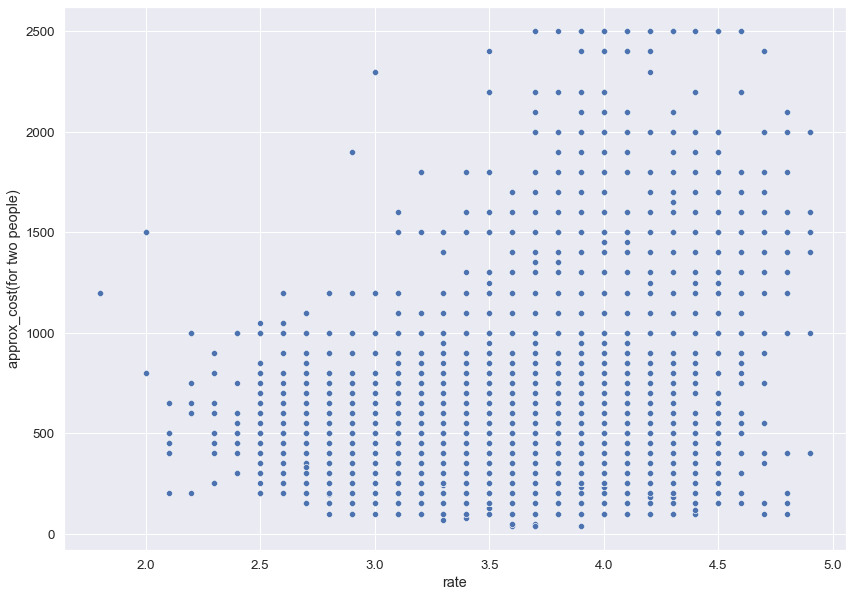

In [48]:
sns.scatterplot(data=df, x='rate', y='approx_cost(for two people)')

<AxesSubplot: xlabel='listed_in(type)', ylabel='votes'>

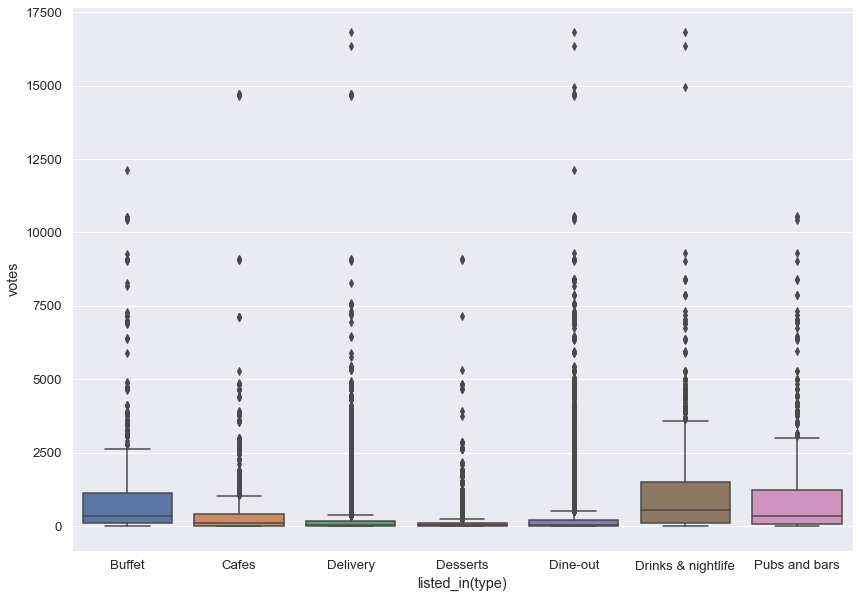

In [49]:
sns.boxplot(data=df, x='listed_in(type)', y='votes')

In [50]:
df[(df['listed_in(type)'] == 'Drinks & nightlife') & (df['votes'] <= 3750)].sort_values(by='votes', ascending=False).head(10)

,approx_cost(for two people),votes,online_order,book_table,listed_in(type),rest_type,listed_in(city),location,cuisines,rate
48783,1300.0,3730,1,1,Drinks & nightlife,"Casual Dining, Irani Cafee",Residency Road,Lavelle Road,"Parsi, North Indian",4.4
43847,1300.0,3712,1,1,Drinks & nightlife,"Casual Dining, Irani Cafee",MG Road,Lavelle Road,"Parsi, North Indian",4.4
46061,1900.0,3659,0,1,Drinks & nightlife,"Lounge, Casual Dining",Old Airport Road,Indiranagar,"Italian, BBQ, Asian, Fast Food",4.3
13233,1300.0,3656,1,1,Drinks & nightlife,"Casual Dining, Irani Cafee",Church Street,Lavelle Road,"Parsi, North Indian",4.4
6610,1300.0,3651,1,1,Drinks & nightlife,"Casual Dining, Irani Cafee",Brigade Road,Lavelle Road,"Parsi, North Indian",4.4
19272,2100.0,3592,0,1,Drinks & nightlife,"Lounge, Casual Dining",Indiranagar,Indiranagar,"Continental, American, Asian, North Indian, Bu...",4.3
17485,1000.0,3573,0,1,Drinks & nightlife,Bar,HSR,HSR,"Continental, Asian, North Indian",4.7
48785,1700.0,3498,1,1,Drinks & nightlife,"Pub, Microbrewery",Residency Road,Lavelle Road,"Continental, BBQ, Finger Food",4.3
43849,1700.0,3496,1,1,Drinks & nightlife,"Pub, Microbrewery",MG Road,Lavelle Road,"Continental, BBQ, Finger Food",4.3
39325,1700.0,3492,1,1,Drinks & nightlife,"Pub, Microbrewery",Lavelle Road,Lavelle Road,"Continental, BBQ, Finger Food",4.3


In [51]:
df = df[df['votes'] <= 3750]

<AxesSubplot: xlabel='votes', ylabel='Count'>

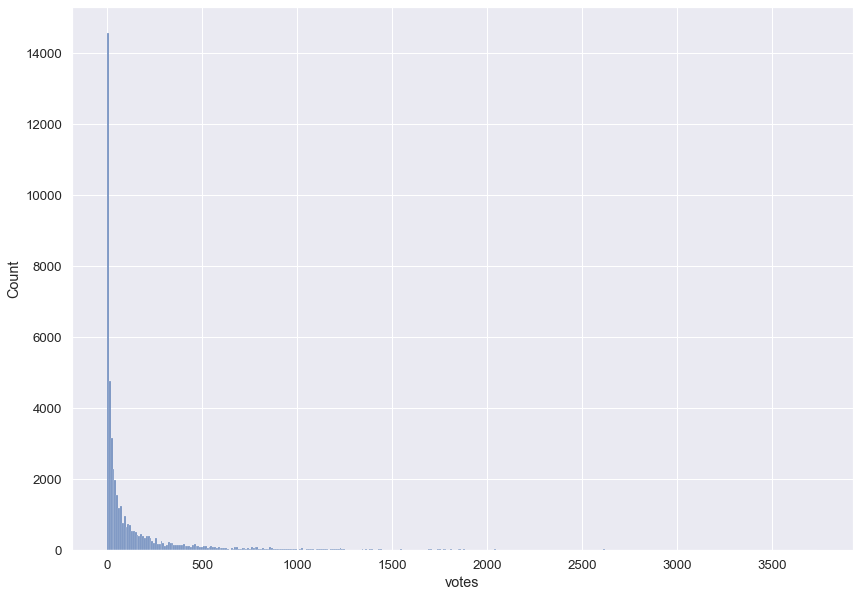

In [52]:
sns.histplot(data=df, x='votes')

<AxesSubplot: xlabel='votes', ylabel='Density'>

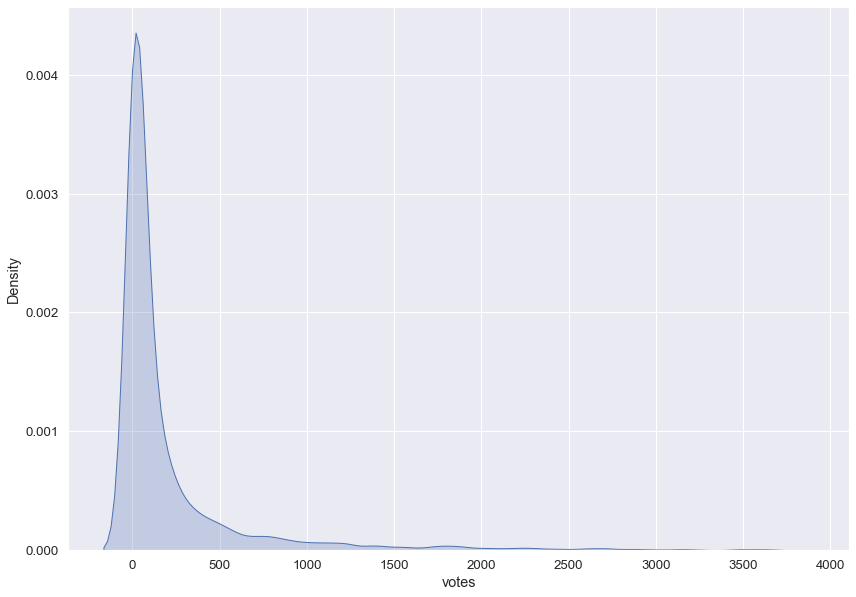

In [53]:
sns.kdeplot(df['votes'], shade=True, color='b')

<AxesSubplot: xlabel='rate', ylabel='votes'>

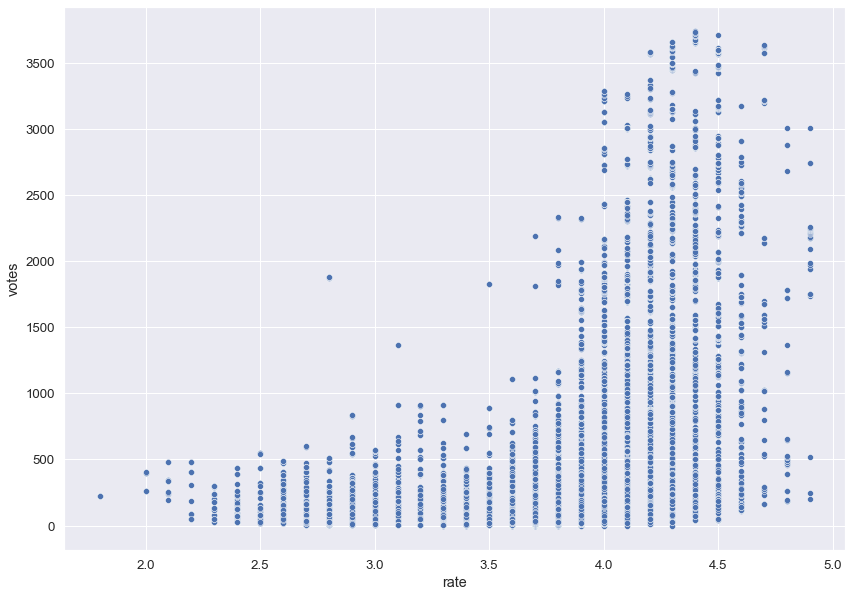

In [54]:
sns.scatterplot(data=df, x='rate', y='votes')

<AxesSubplot: xlabel='online_order', ylabel='count'>

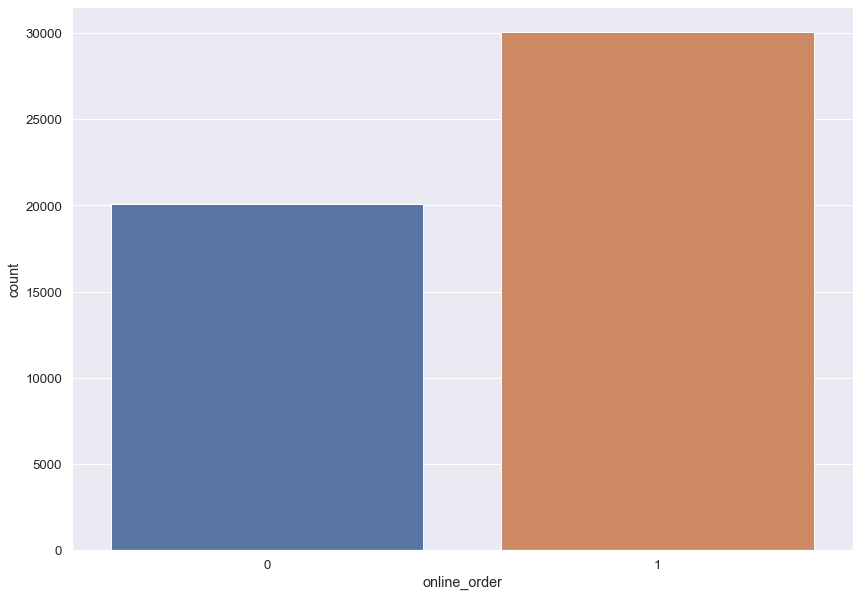

In [55]:
sns.countplot(data=df, x='online_order')

<AxesSubplot: xlabel='book_table', ylabel='count'>

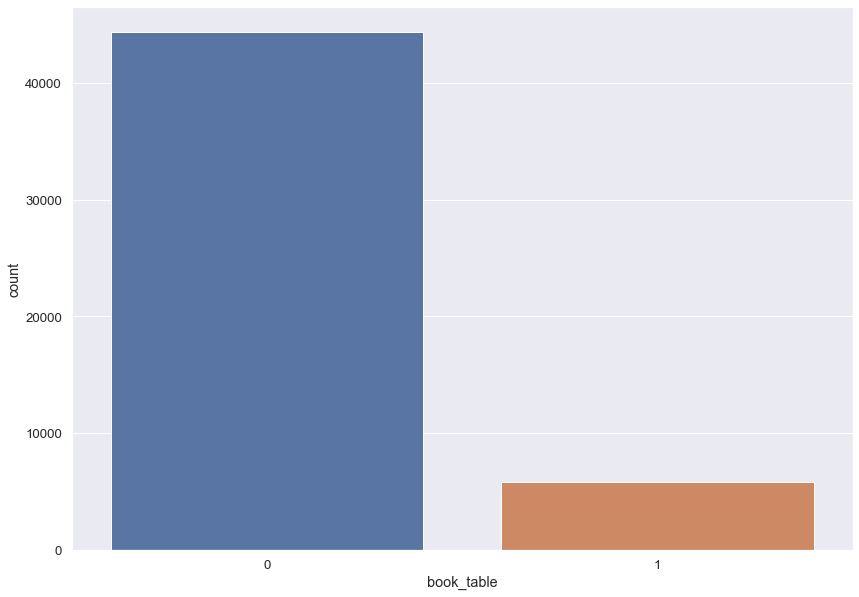

In [56]:
sns.countplot(data=df, x='book_table')

<AxesSubplot: xlabel='rate', ylabel='Count'>

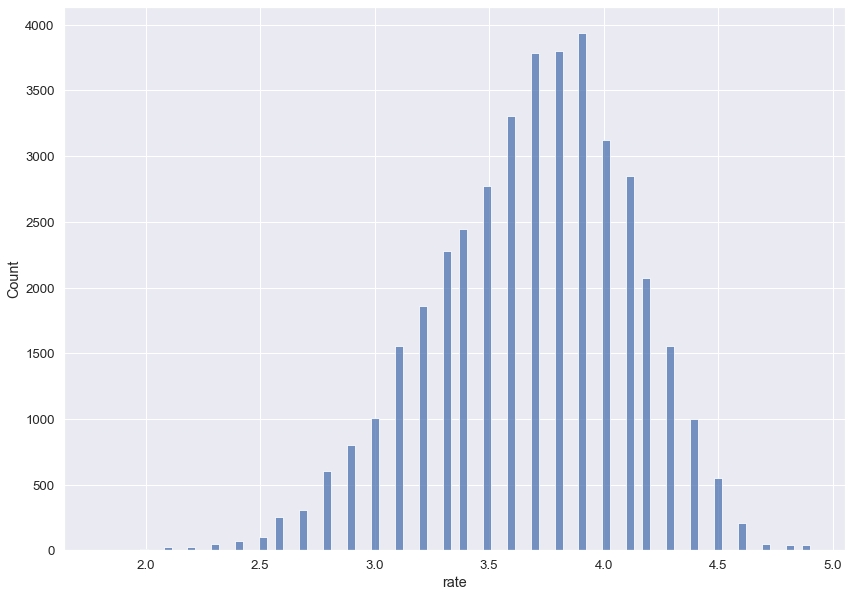

In [57]:
sns.histplot(data=df, x='rate')

<AxesSubplot: xlabel='rate', ylabel='Density'>

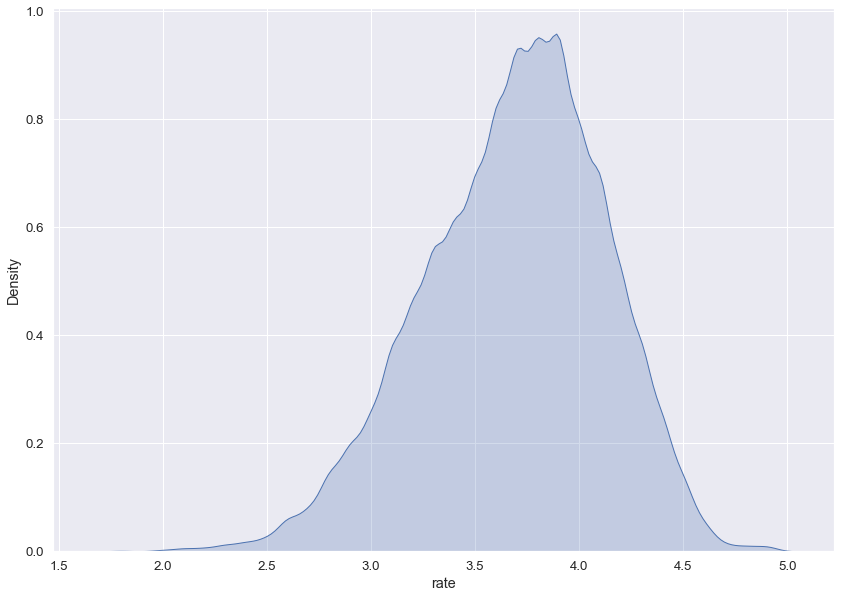

In [58]:
sns.kdeplot(df['rate'], shade=True, color='b')

### Feature Engineering:

- Create `recommended` feature

In [59]:
def recommended(x):
    if x >= 3.7:
        return 1
    else:
        return 0

df['recommended'] = df['rate'].apply(recommended)
df.drop(['rate'], axis=1, inplace=True)

<AxesSubplot: xlabel='recommended', ylabel='count'>

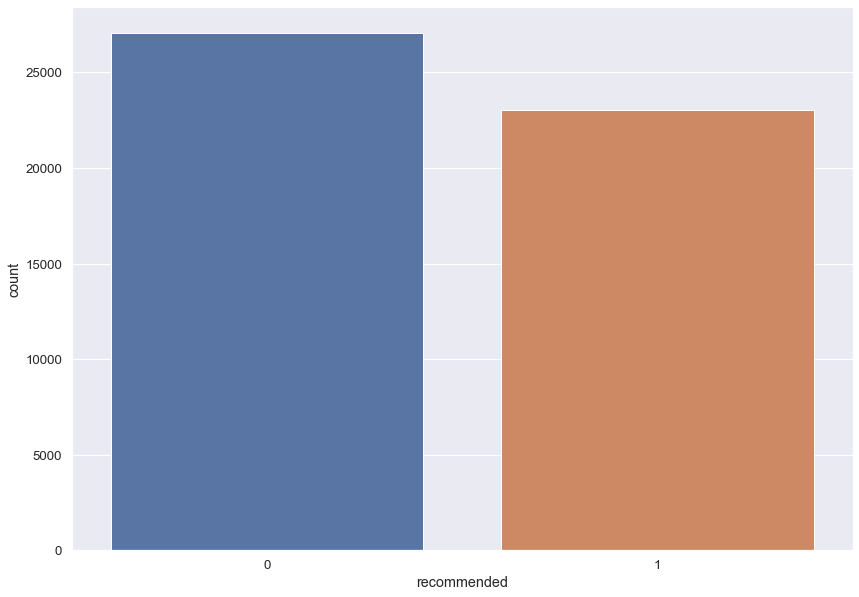

In [60]:
sns.countplot(data=df, x='recommended')

<AxesSubplot: xlabel='approx_cost(for two people)', ylabel='Density'>

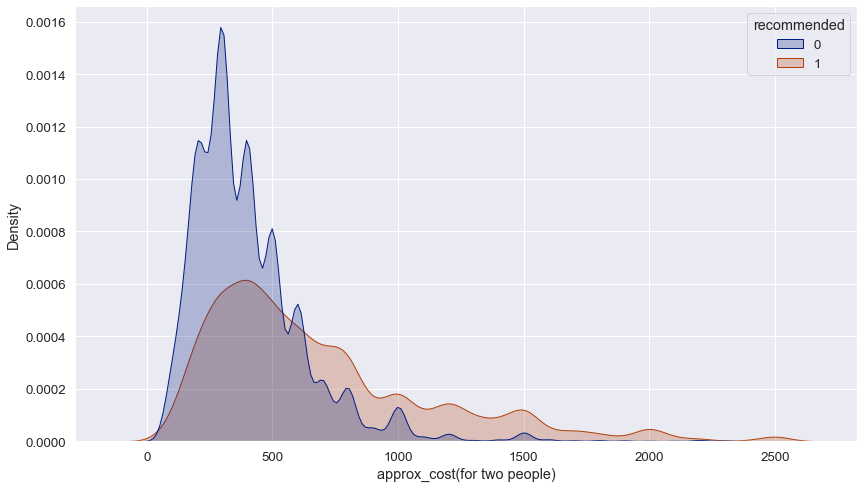

In [61]:
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df, x='approx_cost(for two people)', hue='recommended', palette='dark', fill=True)

<AxesSubplot: xlabel='votes', ylabel='Density'>

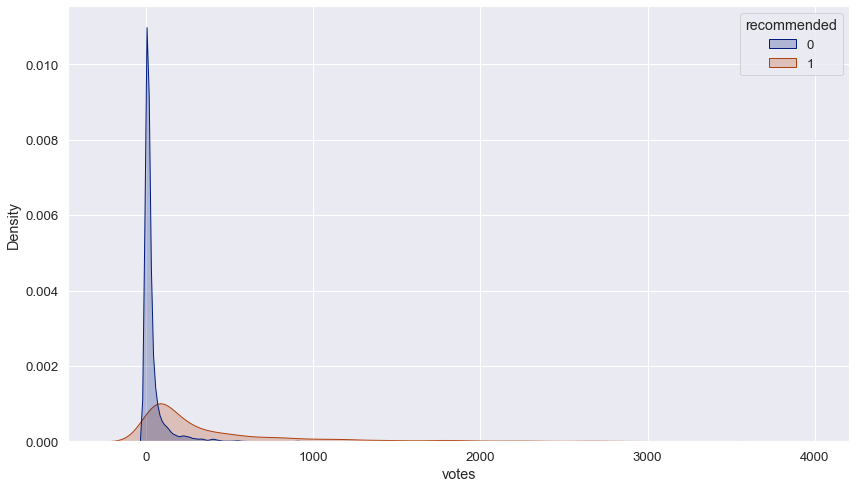

In [62]:
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df, x='votes', hue='recommended', palette='dark', fill=True)

<AxesSubplot: xlabel='online_order', ylabel='count'>

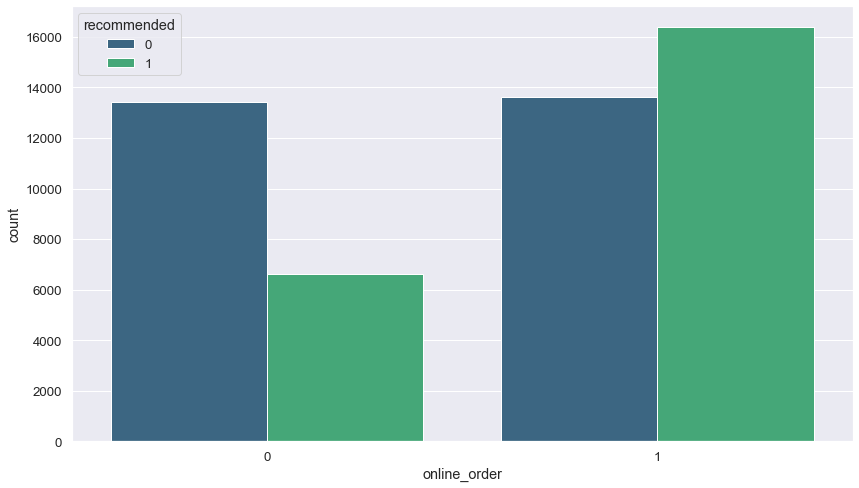

In [63]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='online_order', hue='recommended', palette='viridis')

<AxesSubplot: xlabel='book_table', ylabel='count'>

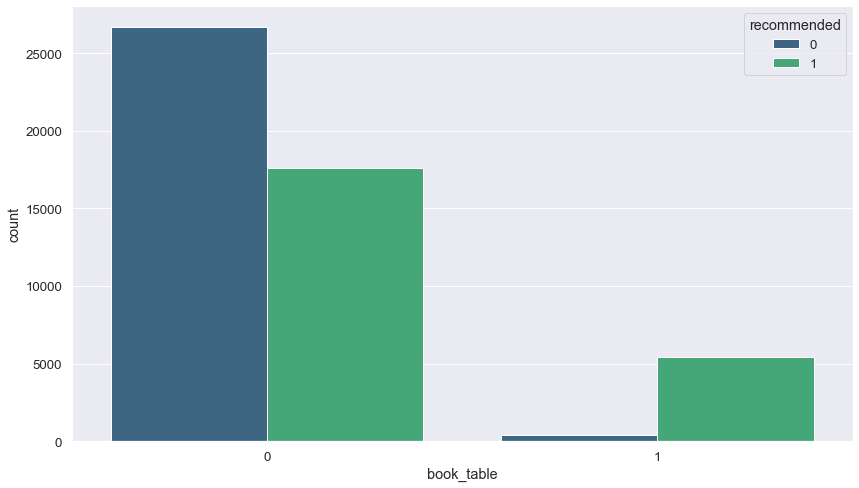

In [64]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='book_table', hue='recommended', palette='viridis')

- `listed_in(type)`, `listed_in(city)` should be converted to numerical

In [65]:
df = pd.get_dummies(df, columns=['listed_in(type)'], prefix='listed_in(type)', prefix_sep='.', drop_first=True, dtype='int64')
df = pd.get_dummies(df, columns=['listed_in(city)'], prefix='listed_in(city)', prefix_sep='.', drop_first=True, dtype='int64')

- Converting `rest_type` to numerical - method (1)

In [ ]:
'''
for i in lst1:
    df[i] = df['rest_type'].apply(lambda x: 1 if i in [j.strip() for j in (str(x).split(','))] else 0)

df = df[df['nan'] != 1]

df.drop(['nan'], axis=1, inplace=True)
'''

- Converting `rest_type` to numerical - method (2)

In [ ]:
#df.groupby('rest_type')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(26) >= 100

In [ ]:
#df.groupby('rest_type')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(25).plot(kind='bar', figsize=(14, 8), color='b')

In [ ]:
#lst6 = list(df.groupby('rest_type')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(25).index)

In [ ]:
'''
def rest_type(x):
    if x in lst6:
        return x
    else:
        return 'Others'

df['rest_type'] = df['rest_type'].apply(rest_type)
'''

In [ ]:
#df['rest_type'].value_counts()

In [ ]:
'''
rest_type_map = {
    lst6[0]:25,
    lst6[1]:24,
    lst6[2]:23,
    lst6[3]:22,
    lst6[4]:21,
    lst6[5]:20,
    lst6[6]:19,
    lst6[7]:18,
    lst6[8]:17,
    lst6[9]:16,
    lst6[10]:15,
    lst6[11]:14,
    lst6[12]:13,
    lst6[13]:12,
    lst6[14]:11,
    lst6[15]:10,
    lst6[16]:9,
    lst6[17]:8,
    lst6[18]:7,
    lst6[19]:6,
    lst6[20]:5,
    lst6[21]:4,
    lst6[22]:3,
    lst6[23]:2,
    lst6[24]:1,
    'Others':0
}

df['rest_type'] = df['rest_type'].map(rest_type_map)
'''

- Converting `location` to numerical

In [ ]:
#df.groupby('location')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(35) >= 200

In [ ]:
#df.groupby('location')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(34).plot(kind='bar', figsize=(14, 8), color='b')

In [ ]:
#lst6 = list(df.groupby('location')['recommended', 'approx_cost(for two people)', 'votes'].sum().sort_values(by='recommended', ascending=False)[['recommended']].head(34).index)

In [ ]:
'''
def location(x):
    if x in lst6:
        return x
    else:
        return 'Others'

df['location'] = df['location'].apply(location)
'''

In [ ]:
#df['location'].value_counts()

In [ ]:
'''
location_map = {
    lst6[0]:34,
    lst6[1]:33,
    lst6[2]:32,
    lst6[3]:31,
    lst6[4]:30,
    lst6[5]:29,
    lst6[6]:28,
    lst6[7]:27,
    lst6[8]:26,
    lst6[9]:25,
    lst6[10]:24,
    lst6[11]:23,
    lst6[12]:22,
    lst6[13]:21,
    lst6[14]:20,
    lst6[15]:19,
    lst6[16]:18,
    lst6[17]:17,
    lst6[18]:16,
    lst6[19]:15,
    lst6[20]:14,
    lst6[21]:13,
    lst6[22]:12,
    lst6[23]:11,
    lst6[24]:10,
    lst6[25]:9,
    lst6[26]:8,
    lst6[27]:7,
    lst6[28]:6,
    lst6[29]:5,
    lst6[30]:4,
    lst6[31]:3,
    lst6[32]:2,
    lst6[33]:1,
    'Others':0
}

df['location'] = df['location'].map(location_map)
'''

- Drop `cuisines`, `location`, `rest_type`

In [66]:
df.drop(['cuisines', 'location', 'rest_type'], axis=1, inplace=True)

- `approx_cost(for two people)` should be converted to integer

In [67]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype('int64')

### Feature Selection:

- Get correlations between the features

In [68]:
features = df[['approx_cost(for two people)', 'votes', 'online_order', 'book_table', 'recommended']]

<AxesSubplot: >

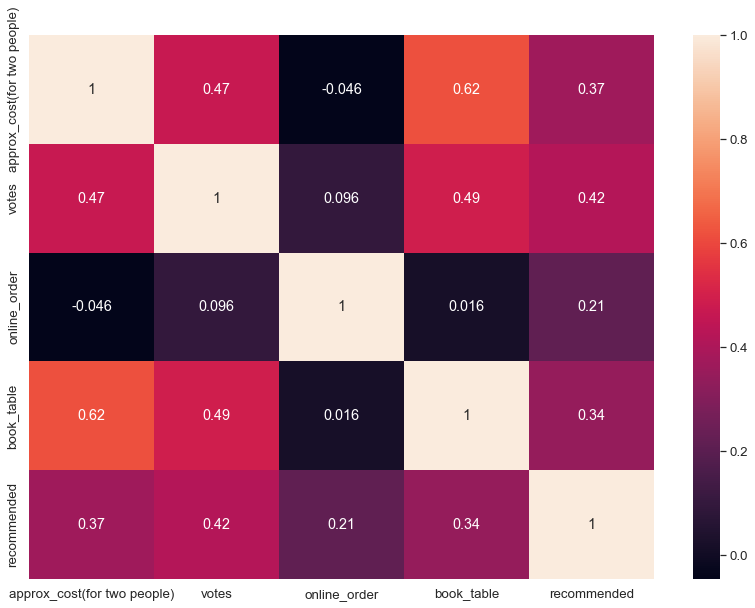

In [69]:
corr = features.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True)

### Splitting Data:

In [70]:
x = df.drop('recommended', axis=1)
y = df['recommended']

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=45)

### Training Data:

- Make `approx_cost(for two people)`, `votes` normally distributed

In [72]:
power = PowerTransformer()
x_train['approx_cost(for two people)'] = power.fit_transform(x_train[['approx_cost(for two people)']])
x_train['votes'] = power.fit_transform(x_train[['votes']])

<AxesSubplot: xlabel='approx_cost(for two people)', ylabel='Density'>

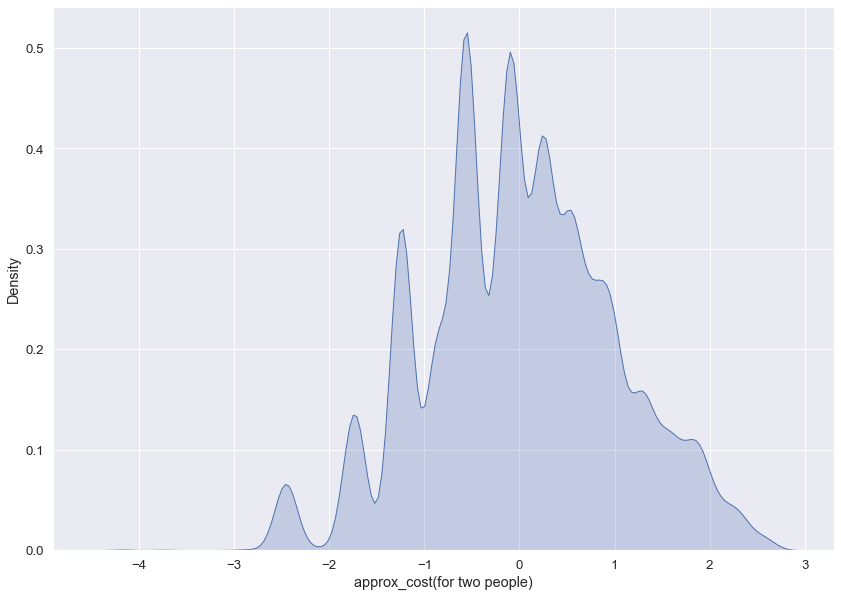

In [73]:
sns.kdeplot(x_train['approx_cost(for two people)'], shade=True, color='b')

<AxesSubplot: xlabel='votes', ylabel='Density'>

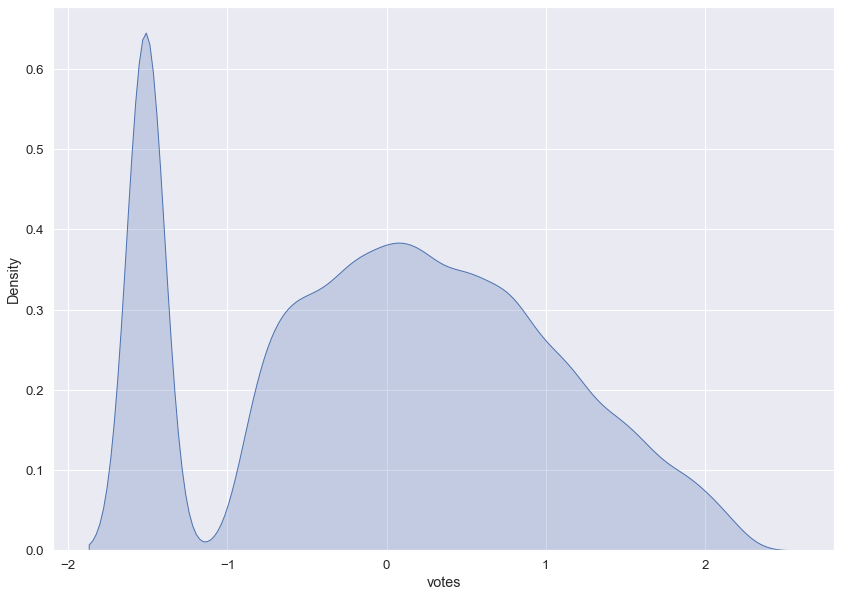

In [74]:
sns.kdeplot(x_train['votes'], shade=True, color='b')

- Standardize the data

In [75]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

- Balancing `recommended` column

In [76]:
x_train, y_train = SMOTE(random_state=85).fit_resample(x_train, y_train)

<AxesSubplot: xlabel='recommended', ylabel='count'>

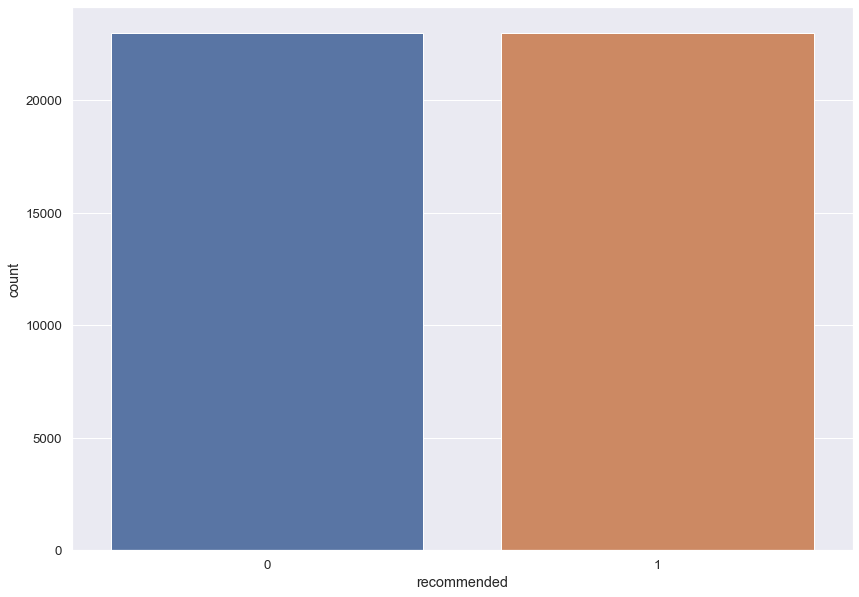

In [77]:
sns.countplot(data = pd.DataFrame(y_train, columns=['recommended']), x='recommended')

### Testing Data:

- Make `approx_cost(for two people)`, `votes` normally distributed

In [78]:
x_test['approx_cost(for two people)'] = power.transform(x_test[['approx_cost(for two people)']])
x_test['votes'] = power.transform(x_test[['votes']])

<AxesSubplot: xlabel='approx_cost(for two people)', ylabel='Density'>

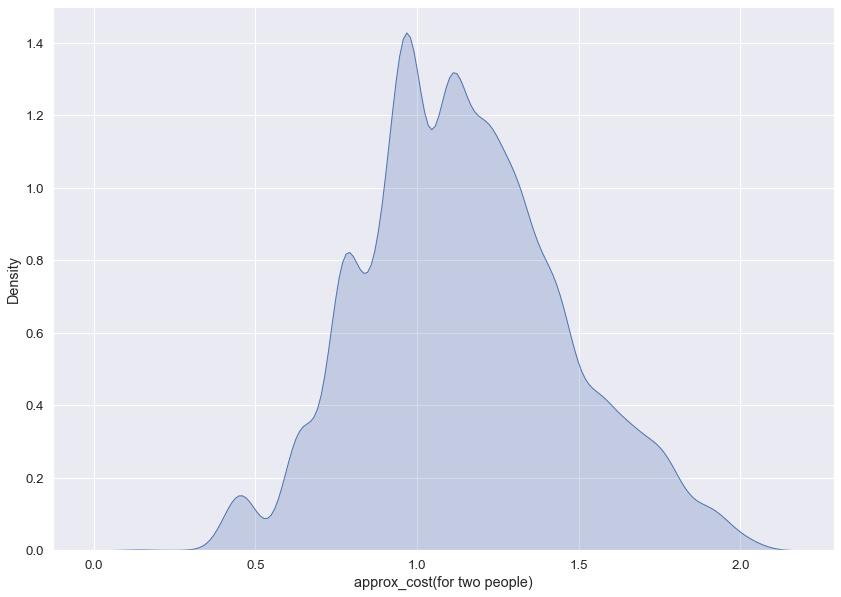

In [79]:
sns.kdeplot(x_test['approx_cost(for two people)'], shade=True, color='b')

<AxesSubplot: xlabel='votes', ylabel='Density'>

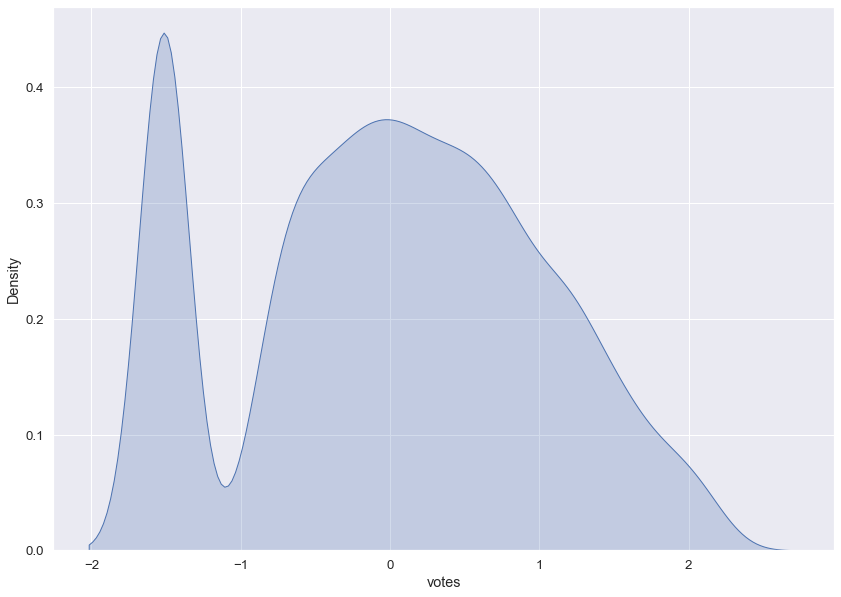

In [80]:
sns.kdeplot(x_test['votes'], shade=True, color='b')

- Standardize the data

In [81]:
x_test = scaler.transform(x_test)

- Balancing `recommended` column

In [82]:
x_test, y_test = SMOTE(random_state=85).fit_resample(x_test, y_test)

<AxesSubplot: xlabel='recommended', ylabel='count'>

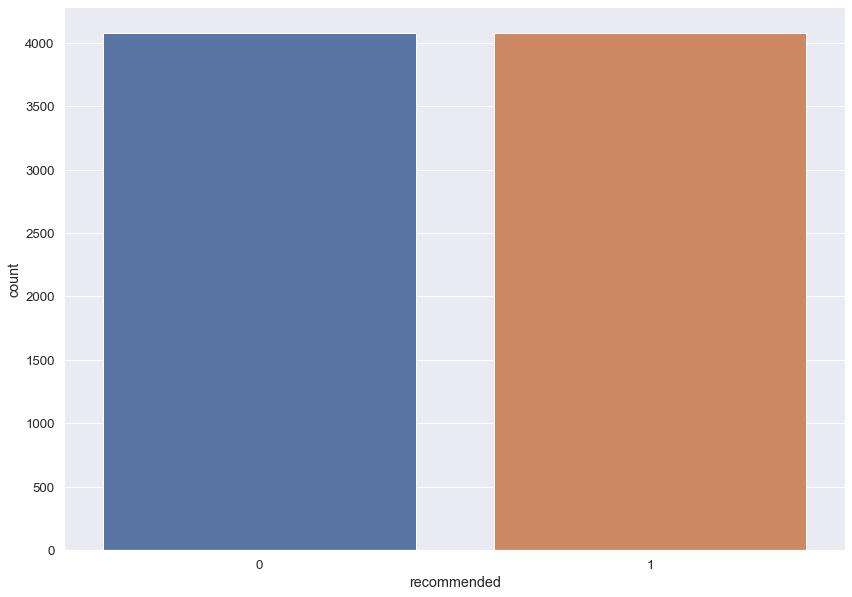

In [83]:
sns.countplot(data = pd.DataFrame(y_test, columns=['recommended']), x='recommended')

### Dimensionality Reduction:

In [ ]:
#features = list(x.columns)
#target = 'recommended'

In [ ]:
#x_train = pd.DataFrame(x_train, columns = features)
#y_train = pd.DataFrame(y_train, columns = [target])
#train = pd.concat([x_train, y_train], axis=1)

In [ ]:
#x_test = pd.DataFrame(x_test, columns = features)
#y_test = pd.DataFrame(y_test, columns = [target])
#test = pd.concat([x_test, y_test], axis=1)

In [ ]:
#df = pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
#features_name = df.drop('recommended', axis=1).columns

In [ ]:
#features_value = df.drop('recommended', axis=1)
#features_value.head()

In [ ]:
#scaler = StandardScaler()
#features_value = scaler.fit_transform(features_value)
#features_value

In [ ]:
#pca = PCA(n_components=6)
#pca.fit(features_value)

In [ ]:
#pca.explained_variance_

In [ ]:
#plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')

In [ ]:
#pca.explained_variance_ratio_

In [ ]:
#plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')

In [ ]:
#principal_components = pca.transform(features_value)
#principal_components

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(principal_components, df['recommended'], test_size=0.15, random_state=19)

### Machine Learning Models:

- Modeling (using grid search)

In [84]:
models={'Bagging':BaggingClassifier(),
        'XGBoost':XGBClassifier(),
        'LightGBM':LGBMClassifier(),
        'CatBoost':CatBoostClassifier()}

In [85]:
HyperGrid = {'Bagging':dict(random_state=[52], n_estimators=[5, 10], max_features=[0.05, 0.7]),
             'XGBoost':dict(random_state=[42], n_estimators=[50, 60, 70], max_depth=[4, 5], learning_rate=[0.4, 0.8]),
             'LightGBM':dict(random_state=[42], n_estimators=[60, 80], num_leaves=[10, 15], max_depth=[3, 5], learning_rate=[0.2, 0.4]),
             'CatBoost':dict(random_state=[12], iterations=[50, 51, 52, 56], max_depth=[2, 5], learning_rate=[0.2, 0.4], silent=[True])}

In [86]:
model_name = []
fitted_model={}
best_models_predictions = {}

for model in models.keys():

    try:
        GS=GridSearchCV(estimator=models[model], param_grid=HyperGrid[model], cv=10, scoring='accuracy')
        GS.fit(x_train, y_train)
        model_name.append(model)
        fitted_model[model] = GS

        train_acc = GS.score(x_train, y_train)
        test_acc = GS.score(x_test, y_test)

        print(" ".join(["For", model, "Algorithm..."]), "\n")
        print("Best train score is %f" % train_acc, "Best test score is %f" % test_acc, "Best parameters are %s" % GS.best_params_, sep="\n")
        print()

        for model in fitted_model.keys():

            print("Train Classification Report\n")
            best_models_predictions[model]=fitted_model[model].best_estimator_.predict(x_train)
            print(classification_report(best_models_predictions[model],y_train))
            print("Test Classification Report\n")
            best_models_predictions[model]=fitted_model[model].best_estimator_.predict(x_test)
            print(classification_report(best_models_predictions[model],y_test))
        
        print("------------------------------------------------------------\n")

        fitted_model={}
    
    except NotFittedError as e:
        print(repr(e))

For Bagging Algorithm... 

Best train score is 0.950030
Best test score is 0.847879
Best parameters are {'max_features': 0.7, 'n_estimators': 10, 'random_state': 52}

Train Classification Report

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     23549
           1       0.94      0.96      0.95     22459

    accuracy                           0.95     46008
   macro avg       0.95      0.95      0.95     46008
weighted avg       0.95      0.95      0.95     46008

Test Classification Report

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      3558
           1       0.91      0.81      0.86      4600

    accuracy                           0.85      8158
   macro avg       0.85      0.85      0.85      8158
weighted avg       0.86      0.85      0.85      8158

------------------------------------------------------------

For XGBoost Algorithm... 

Best train score is 0.885629
Best

- Modeling (using pipeline)

In [87]:
pipelines = []
pipelines.append(('Bagging', Pipeline([('Bagging', BaggingClassifier(random_state=52, n_estimators=10, max_features=0.7))])))
pipelines.append(('XGBoost', Pipeline([('XGBoost', XGBClassifier(random_state=42, n_estimators=60, max_depth=4, learning_rate=0.4))])))
pipelines.append(('LightGBM', Pipeline([('LightGBM', LGBMClassifier(random_state=42, n_estimators=80, num_leaves=15, max_depth=5, learning_rate=0.2))])))
pipelines.append(('CatBoost', Pipeline([('CatBoost', CatBoostClassifier(random_state=48, iterations=100, max_depth=5, learning_rate=0.4, silent=True))])))

In [88]:
models={'Bagging':BaggingClassifier(random_state=52, n_estimators=10, max_features=0.7),
        'XGBoost':XGBClassifier(random_state=42, n_estimators=60, max_depth=4, learning_rate=0.4),
        'LightGBM':LGBMClassifier(random_state=42, n_estimators=80, num_leaves=15, max_depth=5, learning_rate=0.2),
        'CatBoost':CatBoostClassifier(random_state=12, iterations=100, max_depth=5, learning_rate=0.4, silent=True)}

In [89]:
RSKFold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=71)

In [90]:
i = 0
model_name = []
train_results = []
test_results = []
fitted_model = {}
best_models_predictions = {}

for pipe, model in pipelines:
    
    if i < 4:

        train_crossv_results = cross_val_score(model, x_train, y_train, cv=RSKFold, scoring='accuracy')
        test_crossv_results = cross_val_score(model, x_test, y_test, cv=RSKFold, scoring='accuracy')
        train_results.append(train_crossv_results)
        test_results.append(test_crossv_results)
        model_name.append(pipe)

        train_msg = "%s: %f (%f)" % ('Train Accuracy', train_crossv_results.mean(), train_crossv_results.std())
        test_msg = "%s: %f (%f)" % ('Test Accuracy', test_crossv_results.mean(), test_crossv_results.std())
        print(" ".join(["For", model_name[i], "Algorithm..."]), "\n")
        print(train_msg, test_msg, sep='\n')
        print()

        train_fitted = models[model_name[i]].fit(x_train, y_train)
        fitted_model[model_name[i]] = train_fitted

        for model in fitted_model.keys():

            print("Train Classification Report\n")
            best_models_predictions[model]=fitted_model[model].predict(x_train)
            print(classification_report(best_models_predictions[model],y_train))
            print("Test Classification Report\n")
            best_models_predictions[model]=fitted_model[model].predict(x_test)
            print(classification_report(best_models_predictions[model],y_test))
        
        print("------------------------------------------------------------\n")

        i += 1
        fitted_model = {}

For Bagging Algorithm... 

Train Accuracy: 0.862879 (0.003869)
Test Accuracy: 0.832761 (0.011809)

Train Classification Report

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     23549
           1       0.94      0.96      0.95     22459

    accuracy                           0.95     46008
   macro avg       0.95      0.95      0.95     46008
weighted avg       0.95      0.95      0.95     46008

Test Classification Report

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      3558
           1       0.91      0.81      0.86      4600

    accuracy                           0.85      8158
   macro avg       0.85      0.85      0.85      8158
weighted avg       0.86      0.85      0.85      8158

------------------------------------------------------------

For XGBoost Algorithm... 

Train Accuracy: 0.845150 (0.005365)
Test Accuracy: 0.846081 (0.012982)

Train Classification Report



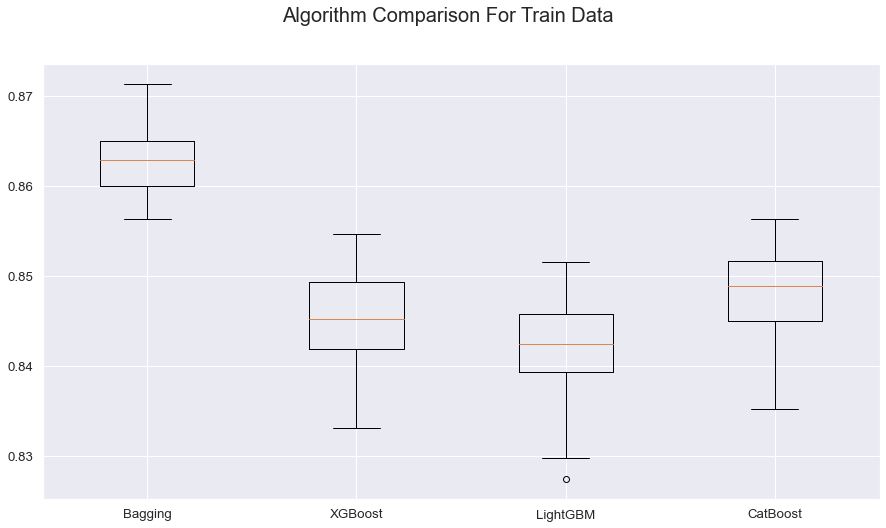

In [91]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison For Train Data', fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(model_name)
plt.show()

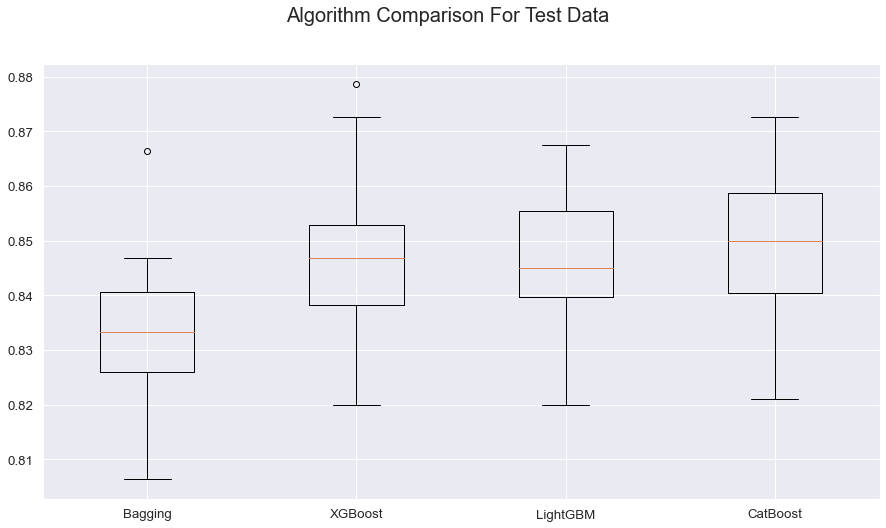

In [92]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison For Test Data', fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(test_results)
ax.set_xticklabels(model_name)
plt.show()

### Deployment:

- `CatBoostClassifier`

In [93]:
model = CatBoostClassifier()

parameters = {
    'random_state':[12],
    'iterations':[50, 51, 52, 56],
    'max_depth':[2, 5],
    'learning_rate':[0.2, 0.4],
    'silent':[True]
}

grid_search = GridSearchCV(model, parameters, cv=10)
grid_search.fit(x_train, y_train)

train_acc = grid_search.score(x_train, y_train)
test_acc = grid_search.score(x_test, y_test)

print(f'Train Accuracy: {train_acc}, Test Accuracy: {test_acc}')

print(f'Best parameters: {grid_search.best_params_}')

Train Accuracy: 0.8501999652234394, Test Accuracy: 0.8461632753125766
Best parameters: {'iterations': 56, 'learning_rate': 0.4, 'max_depth': 5, 'random_state': 12, 'silent': True}


In [94]:
for s, p in zip((grid_search.cv_results_['mean_test_score']), (grid_search.cv_results_['params'])):
    print(f'Mean Test Score: {s}, Parameters: {p}')

Mean Test Score: 0.8332901873883749, Parameters: {'iterations': 50, 'learning_rate': 0.2, 'max_depth': 2, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8375502490006899, Parameters: {'iterations': 50, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8347681458662107, Parameters: {'iterations': 50, 'learning_rate': 0.4, 'max_depth': 2, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8412019646012681, Parameters: {'iterations': 50, 'learning_rate': 0.4, 'max_depth': 5, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8332684340833276, Parameters: {'iterations': 51, 'learning_rate': 0.2, 'max_depth': 2, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8376154900163482, Parameters: {'iterations': 51, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 12, 'silent': True}
Mean Test Score: 0.8345725125917806, Parameters: {'iterations': 51, 'learning_rate': 0.4, 'max_depth': 2, 'random_state': 12, 'silent': True}
Mean T

In [95]:
GS_Results = pd.DataFrame(grid_search.cv_results_['rank_test_score'], columns=['Rank'])
GS_Results['Mean Test Score'] = grid_search.cv_results_['mean_test_score']
GS_Results['Learning Rate'] = grid_search.cv_results_['params'][0]['learning_rate']
GS_Results['Max Depth'] = grid_search.cv_results_['params'][0]['max_depth']
GS_Results['Iterations'] = grid_search.cv_results_['params'][0]['iterations']
GS_Results['Random State'] = grid_search.cv_results_['params'][0]['random_state']
GS_Results

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
0,15,0.833290,0.2,2,50,12
1,8,0.837550,0.2,2,50,12
2,11,0.834768,0.2,2,50,12
3,4,0.841202,0.2,2,50,12
4,16,0.833268,0.2,2,50,12
5,7,0.837615,0.2,2,50,12
6,12,0.834573,0.2,2,50,12
7,3,0.841658,0.2,2,50,12
8,14,0.833312,0.2,2,50,12
9,6,0.837942,0.2,2,50,12


In [96]:
GS_Results = GS_Results.sort_values(by=['Rank'])
GS_Results

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
15,1,0.842071,0.2,2,50,12
11,2,0.841963,0.2,2,50,12
7,3,0.841658,0.2,2,50,12
3,4,0.841202,0.2,2,50,12
13,5,0.838572,0.2,2,50,12
9,6,0.837942,0.2,2,50,12
5,7,0.837615,0.2,2,50,12
1,8,0.837550,0.2,2,50,12
14,9,0.835116,0.2,2,50,12
10,10,0.834790,0.2,2,50,12


In [97]:
GS_Results[GS_Results['Mean Test Score'] == GS_Results['Mean Test Score'].max()]

,Rank,Mean Test Score,Learning Rate,Max Depth,Iterations,Random State
15,1,0.842071,0.2,2,50,12


In [98]:
grid_search

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002955C05DC10>,
             param_grid={'iterations': [50, 51, 52, 56],
                         'learning_rate': [0.2, 0.4], 'max_depth': [2, 5],
                         'random_state': [12], 'silent': [True]})

In [99]:
x

,approx_cost(for two people),votes,online_order,book_table,listed_in(type).Cafes,listed_in(type).Delivery,listed_in(type).Desserts,listed_in(type).Dine-out,listed_in(type).Drinks & nightlife,listed_in(type).Pubs and bars,...,listed_in(city).Lavelle Road,listed_in(city).MG Road,listed_in(city).Malleshwaram,listed_in(city).Marathahalli,listed_in(city).New BEL Road,listed_in(city).Old Airport Road,listed_in(city).Rajajinagar,listed_in(city).Residency Road,listed_in(city).Sarjapur Road,listed_in(city).Whitefield
0,800,775,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,800,787,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,800,918,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,300,88,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,600,166,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,1500,27,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
51713,600,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
51714,2000,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
51715,2500,236,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [100]:
approx_cost = int(input('Enter the cost for two people: '))

votes = int(input('Enter the number of votes: '))

online_order = input('Enter the online order option: ')
if (online_order == 'Yes'):
    online_order = 1
elif (online_order == 'No'):
    online_order = 0

book_table = input('Enter the table booking option: ')
if (book_table == 'Yes'):
    book_table = 1
elif (book_table == 'No'):
    book_table = 0

'''
rest_type = input('Enter the restaurant type option: ')
if (rest_type == 'Casual Dining'):
    rest_type = 25
elif (rest_type == 'Quick Bites'):
    rest_type = 24
elif (rest_type == 'Cafe'):
    rest_type = 23
elif (rest_type == 'Dessert Parlor'):
    rest_type = 22
elif (rest_type == 'Casual Dining, Bar'):
    rest_type = 21
elif (rest_type == 'Delivery'):
    rest_type = 20
elif (rest_type == 'Takeaway, Delivery'):
    rest_type = 19
elif (rest_type == 'Bar'):
    rest_type = 18
elif (rest_type == 'Bakery'):
    rest_type = 17
elif (rest_type == 'Bar, Casual Dining'):
    rest_type = 16
elif (rest_type == 'Pub'):
    rest_type = 15
elif (rest_type == 'Beverage Shop'):
    rest_type = 14
elif (rest_type == 'Casual Dining, Cafe'):
    rest_type = 13
elif (rest_type == 'Lounge'):
    rest_type = 12
elif (rest_type == 'Pub, Casual Dining'):
    rest_type = 11
elif (rest_type == 'Food Court'):
    rest_type = 10
elif (rest_type == 'Sweet Shop'):
    rest_type = 9
elif (rest_type == 'Beverage Shop, Quick Bites'):
    rest_type = 8
elif (rest_type == 'Fine Dining'):
    rest_type = 7
elif (rest_type == 'Dessert Parlor, Cafe'):
    rest_type = 6
elif (rest_type == 'Cafe, Bakery'):
    rest_type = 5
elif (rest_type == 'Cafe, Dessert Parlor'):
    rest_type = 4
elif (rest_type == 'Cafe, Casual Dining'):
    rest_type = 3
elif (rest_type == 'Microbrewery, Casual Dining'):
    rest_type = 2
elif (rest_type == 'Casual Dining, Pub'):
    rest_type = 1
elif (rest_type == 'Others'):
    rest_type = 0
'''

listed_in_type = input('Enter the listed in type option: ')
if (listed_in_type == 'Cafes'):
    listed_in_type = [1, 0, 0, 0, 0, 0]
elif (listed_in_type == 'Delivery'):
    listed_in_type = [0, 1, 0, 0, 0, 0]
elif (listed_in_type == 'Desserts'):
    listed_in_type = [0, 0, 1, 0, 0, 0]
elif (listed_in_type == 'Dine-out'):
    listed_in_type = [0, 0, 0, 1, 0, 0]
elif (listed_in_type == 'Drinks & nightlife'):
    listed_in_type = [0, 0, 0, 0, 1, 0]
elif (listed_in_type == 'Pubs and bars'):
    listed_in_type = [0, 0, 0, 0, 0, 1]
elif (listed_in_type == 'Buffet'):
    listed_in_type = [0, 0, 0, 0, 0, 0]

listed_in_city = input('Enter the listed in city option: ')
if (listed_in_city == 'Banashankari'):
    listed_in_city = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Bannerghatta Road'):
    listed_in_city = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Basavanagudi'):
    listed_in_city = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Bellandur'):
    listed_in_city = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Brigade Road'):
    listed_in_city = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Brookefield'):
    listed_in_city = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Church Street'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Electronic City'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Frazer Town'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'HSR'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Indiranagar'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'JP Nagar'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Jayanagar'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Kalyan Nagar'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Kammanahalli'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Koramangala 4th Block'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Koramangala 5th Block'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Koramangala 6th Block'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Koramangala 7th Block'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Lavelle Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'MG Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Malleshwaram'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Marathahalli'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
elif (listed_in_city == 'New BEL Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
elif (listed_in_city == 'Old Airport Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
elif (listed_in_city == 'Rajajinagar'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
elif (listed_in_city == 'Residency Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
elif (listed_in_city == 'Sarjapur Road'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
elif (listed_in_city == 'Whitefield'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
elif (listed_in_city == 'BTM'):
    listed_in_city = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

row_data = [approx_cost, votes, online_order, book_table]
row_data.extend(listed_in_type)
row_data.extend(listed_in_city)
print(row_data)

[800, 175, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [101]:
grid_search.predict(scaler.transform([row_data]))

array([1], dtype=int64)

In [102]:
joblib.dump(grid_search, "model.h5")
joblib.dump(power, "power.h5")
joblib.dump(scaler, "scaler.h5")

['scaler.h5']

In [103]:
mo = joblib.load("model.h5")
po = joblib.load("power.h5")
sc = joblib.load("scaler.h5")

In [104]:
mo.predict(sc.transform([row_data]))

array([1], dtype=int64)